# POLICY SEARCH AGENT
An AI agent that updates its policy model with each episode until it reaches optimization.

## Setup

In [ ]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
'''
Imports
'''
#!pip install q tensorflow==2.3.0
#!pip install q keras==2.2.4
#!pip install utils

import os
os.chdir('..')
import matplotlib.pyplot as plt
import time
import itertools
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

import numpy as np
import sys
import random
from collections import namedtuple
import collections
import copy

# Import the open AI gym
import gym
import keras

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from keras import initializers


# from tensorflow.keras.layers.experimental import RandomFourierFeatures

from gym.envs.toy_text import discrete

# The basics
%matplotlib inline
import virl
import utils

# basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing

# Policy stuff?
import pandas as pd
from keras.models import Sequential

In [74]:
tf.__version__

'1.15.0'

# Plotting stats function

In [120]:
# define a couple of helper functions to plot the results

def plot_graphs(episode):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Fig 1: States
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(episode.states)
    #print(states.shape)
    for i in range(4):
        axes[0].plot(states[:,i], label=labels[i]);
    axes[0].set_title('States')
    axes[0].set_xlabel('weeks since start of epidemic')
    axes[0].set_ylabel('State s(t)')
    axes[0].legend()
    
    # Fig 2: Actions
    axes[1].plot(episode.actions);
    axes[1].set_title('Action')
    axes[1].set_xlabel('weeks since start of epidemic')
    axes[1].set_ylabel('Action a(t)')
    
    # Fig 3: Rewards 
    axes[2].plot(episode.rewards);
    axes[2].set_title('Reward, total: ' + str(sum(episode.rewards)))
    axes[2].set_xlabel('weeks since start of epidemic')
    axes[2].set_ylabel('reward r(t)')

    #print('total reward', np.sum(rewards))
        
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

# Episodes

In [121]:
'''
Define couple of named tuples to hold useful episode information
EpisodeStats: Information about episode length and total reward for episode
EpisodeSteps: Information about the state entered, action taken and reward obtained in each step
'''

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])
EpisodeSteps = namedtuple("Steps", ["states", "actions", "rewards"])

# Policy Class

In [123]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, layers, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.layers = layers
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.layers)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.layers),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.layers)

In [135]:
GLOBAL_SEED=42

class PolicySearchAgent:
    '''
    An AI Agent that adjusts the policy function (which maps states to actions) to improve its performance
    Achieves this by parameterizing the policy function which could allow it to be differentiable and updating the 
    parameters until the policy reaches optimization
    '''
    def __init__(self, env, alpha=1, gamma=1):
        """

        :param alpha the learning rate
        :param gamma discount rate
        :param rbf_type can be "gaussian" or "laplacian". See RandomFourierFeatures
        """
        # Neural network vars
        self.dim_action = env.actions.shape
        self.dim_observation = env.observation_space.shape
        self.alpha = alpha
        
        self.n_states = env.action_space.n # take the state value directly
        
        # Update vars
        self.gamma = gamma
        self.episode = EpisodeSteps(states=[], actions=[], rewards=[])
        self.steps = 0 
        
        # Build and train neural network
        self.__build_model()
        self.__build_train_fn()
        
    '''
    Tabular methods implementation of build_model = constructing a neural network
    Creates a stochastic policy representation that is differentiable, using softmax function
    '''
    def __build_model(self):
        # print("build: " + str(self.dim_observation))
        self.X = layers.Input(shape=(self.n_states,))
        net = self.X
        net = RBFLayer(20,self.gamma)(net)
        net = layers.Dense(self.n_states, kernel_initializer=initializers.Zeros())(net)
        net = layers.Activation("softmax")(net)
        self.model = Model(inputs=self.X, outputs=net)
        
    '''
    Tabular methods implementation of build_fn = training the neural network
    Custom train function that that replaces `model.fit(X, y)`because we use the output of model and use it for training
    Called using self.train_fn([state, action_one_hot, target])` which would train the model
    '''
    def __build_train_fn(self):
        # predefine a few variables
        action_onehot_placeholder = K.placeholder(shape=(None, self.dim_action[0]),name="action_onehot") # define a variable
        target = K.placeholder(shape=(None,), name="target") # define a variable       
        
        # this part defines the loss and is very important!
        action_prob = self.model.output # the output of the neural network        
        action_selected_prob = K.sum(action_prob * action_onehot_placeholder, axis=1) # probability of the selcted action        
        log_action_prob = K.log(action_selected_prob) # take the log
        loss = -log_action_prob * target # the loss we are trying to minimise
        loss = K.mean(loss)
        
        # defining the speific optimizer to use
        adam = optimizers.Adam(lr=self.alpha)# clipnorm=1000.0) # let's use a kereas optimiser called Adam
        updates = adam.get_updates(params=self.model.trainable_weights, loss=loss) # what gradient updates to we parse to Adam
            
        
        # create a handle to the optimiser function    
        self.train_fn = K.function(inputs=[self.model.input, action_onehot_placeholder, target],
                                   outputs=[],
                                   updates=updates) # return a function which, when called, takes a gradient step

        
    '''
    Tabular methods using discretized state space, digitizes a state into a set of bins
    Encodes the state as one-hot
    '''
    def get_state_encoding(self, state):
        # Create a set of bins to put vallues into
        #bins = np.linspace(0, self.population, self.bins+1)
        # print(np.log(np.array(state) + 1))
        return np.log(np.array(state) + 1)
    
    '''
    Make prediction in current state of policy function, using the discretized state space for this task
    ''' 
    def predict(self, state, action=None):
        log_state = self.get_state_encoding(state).reshape((1,4))
        if action is None:            
            return self.model.predict(log_state).squeeze()
        else:   
            return self.model(log_state)[action]
    
    '''
    Incrementing the policy search object to update it with new values at each simulation step, once episode length is 
    reached process the data obtained during episode to update the parameters of the policy search function
    '''
    def increment(self, state, action, reward):
        # During episode, increment steps and store latest state, action and reward values
        self.steps += 1
        self.episode.states.append(state)
        self.episode.actions.append(action)
        self.episode.rewards.append(reward)
            
    '''
    Once an episode has ended, calculate the gradient of the policy function and retrain it with new parameters
    '''
    def update_model(self):
        # Go through the episode, step-by-step and make policy updates (note we sometime use j for the individual steps)
        for i in range(self.steps):   
            # Get one-hot encodings of action-space, while log state gets converted to log space
            # TODO (for Fahad): determine if log space is still effective here
            log_state = self.get_state_encoding(self.episode.states[i]).reshape((1,4))
            action_onehot = np_utils.to_categorical(self.episode.actions[i], num_classes=self.dim_action[0]) 

            # The return, G_t, after this timestep; this is the target for the PolicyEstimator
            G_t = sum(self.gamma**n * r for n, r in enumerate(self.episode.rewards[i:]))

            # Update our policy estimator
            self.train_fn([log_state, action_onehot, np.array(G_t)]) # call the custom optimiser which takes a gradient step
        
    '''
    Reset episode data
    '''
    def reset(self):
        self.steps = 0
        self.episode = EpisodeSteps(states=[], actions=[], rewards=[])

In [23]:
layers.Dense(4,activation="softmax",kernel_initializer=initializers.glorot_normal(seed=GLOBAL_SEED))

In [125]:
def create_policy(func_approximator):
    """
    Create a greedy policy with the exploration defined by the epsilon and nA parameters
    
    args:
    - func_approximator: a function approximator that gives the probability Q(s, a) for a given state s
    - num_actions: the number of actions
    
    return: A policy function. Policy functions take a state as input and return an action to perform.
    """
    
    def policy_fn(state):
        """
        Perform an action.
        
        Returns: q_values is the actual value returned by the approximator.
        """
        q_values = func_approximator.predict(func_approximator.get_state_encoding(state))
        return q_values
    
    return policy_fn

# SIMULATION

Episode: 499
0 [3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3]


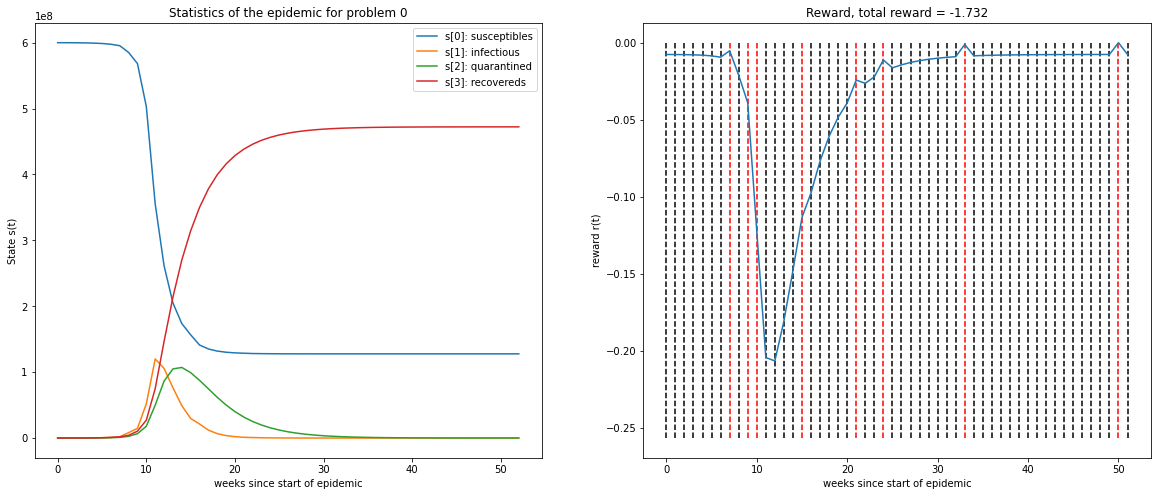

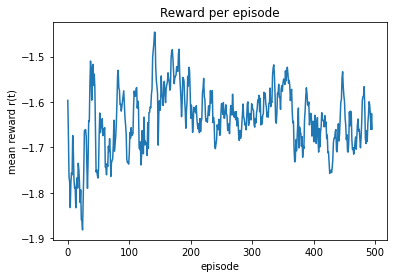

In [140]:
env = virl.Epidemic(stochastic=False, noisy=False)
"""
Args:
    stochastic (bool): Is the infection rate sampled from some distribution at the beginning of each episode (default: False)?
    noisy (bool): Is the state a noisy estimate of the true state (default: False)?
    problem_id (int): Deterministic parameterization of the epidemic (default: 0).
"""

num_episodes = 500
episode_counter = 0

stats = EpisodeStats(episode_lengths=[], episode_rewards=[])
# Set up policy search agent
ps_agent = PolicySearchAgent(env, alpha=0.01, gamma=0.4)


for i in range(num_episodes):
    # Set up initial state
    states = []

    s = env.reset()
    states.append(s)
    done = False

    # Run simulation
    while not done:
        # Get policy to give set of action probs based on latest state and choose largest prob
        action_probs = ps_agent.predict(states[-1])
        choice = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        # Make a step in environemnt
        s, r, done, i = env.step(action=choice) 

        # Update policy
        ps_agent.increment(s, choice, r)

    # Debug info
    print("\rEpisode: " + str(episode_counter),end="")
    #print("Action Probabilities: " + str(action_probs))
    # plot_states_and_rewards(states, rewards)
    # plot_graphs(ps_agent.episode)

    episode_counter += 1

    # Save episode's total reward
    stats.episode_lengths.append(ps_agent.steps)
    stats.episode_rewards.append(sum(ps_agent.episode.rewards))

    # Update model to learn from the rewards of current episode
    ps_agent.update_model()

    # Reset ps_agent's episode data
    ps_agent.reset()

print()
approximator_ps = ps_agent
utils.evaluate(create_policy(approximator_ps))
utils.plot_avg_reward(stats.episode_rewards)

# Results

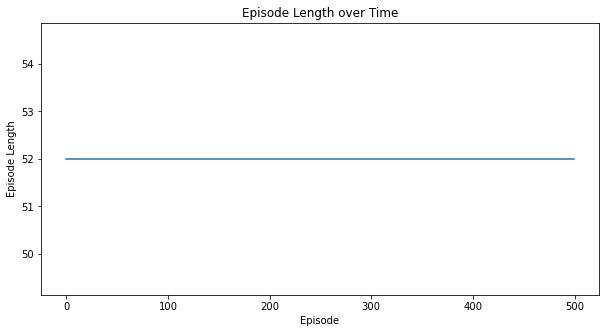

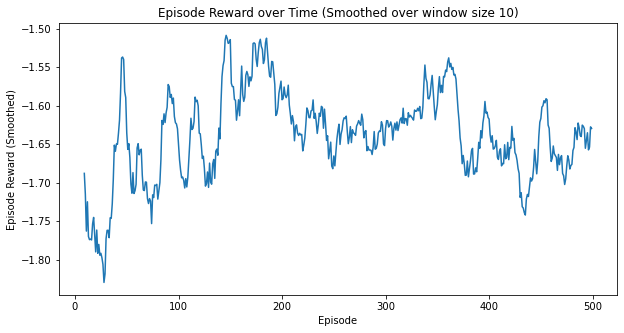

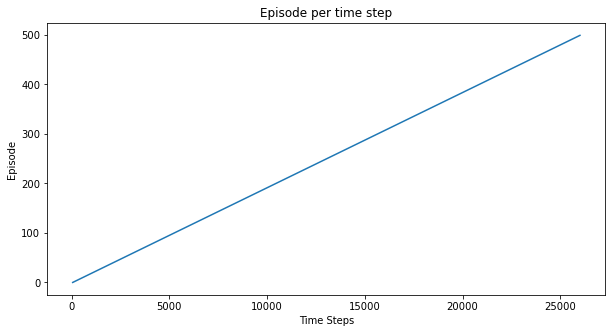

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [141]:
#print(stats)
plot_episode_stats(stats)